Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [ ]:
! pip install datasets
! pip install transformers

     |████████████████████████████████| 325 kB 4.1 MB/s 
     |████████████████████████████████| 212 kB 44.6 MB/s 
     |████████████████████████████████| 1.1 MB 41.3 MB/s 
     |████████████████████████████████| 134 kB 50.4 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 127 kB 21.8 MB/s 
     |████████████████████████████████| 271 kB 32.0 MB/s 
     |████████████████████████████████| 144 kB 35.5 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 3.8 MB 4.4 MB/s 


For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [ ]:
from datasets import (load_dataset, list_datasets)

In [ ]:
dataset = load_dataset('yahoo_answers_topics', cache_dir="sample_data", ignore_verifications=True) # the result is a dataset dictionary of train and test splits in this case

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to sample_data/yahoo_answers_topics/yahoo_answers_topics/1.0.0/b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# Fine-tuning the model** (20 points)

In [ ]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [ ]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
import numpy as np
import random

random_state=3
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

###1. Load tokenizer and model

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [ ]:
model = ElectraForMaskedLM.from_pretrained(TOKENIZER_NAME)

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

###2. Look at the predictions of the model as-is before any fine-tuning

In [ ]:
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

In [ ]:
fill_mask("Why don't you ask [MASK]?")

[{'score': 0.5342992544174194,
  'sequence': "why don't you ask me?",
  'token': 2033,
  'token_str': 'm e'},
 {'score': 0.08196018636226654,
  'sequence': "why don't you ask questions?",
  'token': 3980,
  'token_str': 'q u e s t i o n s'},
 {'score': 0.04395333677530289,
  'sequence': "why don't you ask them?",
  'token': 2068,
  'token_str': 't h e m'},
 {'score': 0.04017288610339165,
  'sequence': "why don't you ask why?",
  'token': 2339,
  'token_str': 'w h y'},
 {'score': 0.030024440959095955,
  'sequence': "why don't you ask yourself?",
  'token': 4426,
  'token_str': 'y o u r s e l f'}]

In [ ]:
fill_mask("What is [MASK]")

[{'score': 0.9262322783470154,
  'sequence': 'what is?',
  'token': 1029,
  'token_str': '?'},
 {'score': 0.05156780779361725,
  'sequence': 'what is.',
  'token': 1012,
  'token_str': '.'},
 {'score': 0.021510401740670204,
  'sequence': 'what is!',
  'token': 999,
  'token_str': '!'},
 {'score': 0.0001196492012240924,
  'sequence': 'what is -',
  'token': 1011,
  'token_str': '-'},
 {'score': 0.00010928419214906171,
  'sequence': 'what is "',
  'token': 1000,
  'token_str': '"'}]

In [ ]:
fill_mask("Let's talk about [MASK] physics")

[{'score': 0.24027501046657562,
  'sequence': "let's talk about quantum physics",
  'token': 8559,
  'token_str': 'q u a n t u m'},
 {'score': 0.21258601546287537,
  'sequence': "let's talk about theoretical physics",
  'token': 9373,
  'token_str': 't h e o r e t i c a l'},
 {'score': 0.056394025683403015,
  'sequence': "let's talk about particle physics",
  'token': 10811,
  'token_str': 'p a r t i c l e'},
 {'score': 0.0332079641520977,
  'sequence': "let's talk about real physics",
  'token': 2613,
  'token_str': 'r e a l'},
 {'score': 0.022627945989370346,
  'sequence': "let's talk about mathematical physics",
  'token': 8045,
  'token_str': 'm a t h e m a t i c a l'}]

### 3. Convert best_answer to the input tokens 

In [ ]:
import pandas as pd

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 60000
    })
})

In [ ]:
train_class_sample = 1000

In [ ]:
#train_test = pd.DataFrame(dataset["train"][:30000])
#train_test = train_test.groupby('topic').apply(lambda x: x.sample(train_class_sample, random_state=random_state))
train_test = pd.DataFrame(dataset["train"][:100000])
train_test.head()

,id,topic,question_title,question_content,best_answer
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,3,6,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,4,6,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [ ]:
train_test.topic.value_counts()

6    23634
4    12111
1    10888
3     9282
2     8722
9     7443
5     7316
8     7210
7     7024
0     6370
Name: topic, dtype: int64

In [ ]:
X = train_test.drop(columns=["topic"])
Y = train_test.topic

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state, shuffle=True, stratify=Y)


In [ ]:
val_class_sample=500

In [ ]:
#val = pd.DataFrame(dataset["test"][:30000])
#val= val.groupby('topic').apply(lambda x: x.sample(val_class_sample, random_state=random_state))
val = pd.DataFrame(dataset["test"][:30000])
val.head()

,id,topic,question_title,question_content,best_answer
0,0,8,What makes friendship click?,How does the spark keep going?,good communication is what does it. Can you m...
1,1,1,Why does Zebras have stripes?,What is the purpose or those stripes? Who do t...,this provides camouflage - predator vision is ...
2,2,3,What did the itsy bitsy sipder climb up?,,waterspout
3,3,3,What is the difference between a Bachelors and...,,One difference between a Bachelors and a Maste...
4,4,2,Why do women get PMS?,,Premenstrual syndrome (PMS) is a group of symp...


In [ ]:
val.topic.value_counts()

6    4311
3    3193
4    3072
1    3010
8    3005
2    2869
9    2710
5    2704
0    2660
7    2466
Name: topic, dtype: int64

In [ ]:
X_val = val.drop(columns=["topic"])
y_val = val.topic

In [ ]:
def tokenize_function(examples):
    return tokenizer.encode_plus(examples, 
                                 add_special_tokens = True, 
                                 padding="max_length",
                                 truncation=True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt')

In [ ]:
train_tokenized_input_ids = []
train_tokenized_attention_mask = []

for sent in X_train["best_answer"].tolist():
    encoded_dict = tokenize_function(sent)

    train_tokenized_input_ids.append(encoded_dict["input_ids"])
    train_tokenized_attention_mask.append(encoded_dict["attention_mask"])

print('Original: ', X_train["best_answer"].values[0])
print('Token IDs:', train_tokenized_input_ids[0])


test_tokenized_input_ids = []
test_tokenized_attention_mask = []

for sent in X_test["best_answer"].tolist():
    encoded_dict = tokenize_function(sent)

    test_tokenized_input_ids.append(encoded_dict["input_ids"])
    test_tokenized_attention_mask.append(encoded_dict["attention_mask"])
    
print('Original: ', X_test["best_answer"].values[0])
print('Token IDs:', test_tokenized_input_ids[0])


val_tokenized_input_ids = []
val_tokenized_attention_mask = []

for sent in X_val["best_answer"].tolist():
    encoded_dict = tokenize_function(sent)

    val_tokenized_input_ids.append(encoded_dict["input_ids"])
    val_tokenized_attention_mask.append(encoded_dict["attention_mask"])

print('Original: ', X_val["best_answer"].values[0])
print('Token IDs:', val_tokenized_input_ids[0])

Original:  Deleting Your Account \nYahoo! members can remove their own accounts and account information from Yahoo!. Please follow the instructions below to initiate the deletion of your account. \nBy terminating your account, you will lose access to your Yahoo! ID, Yahoo! Mail, and profile names. We will also delete your account data and settings across the Yahoo! network. This includes any contents in: \n\nYahoo! Mail \nYahoo! Address Book \nHotJobs \nGeoCities \nYahoo! Briefcase \nMy Yahoo! \nYahoo! Groups \nFinance Portfolio \nany other area of Yahoo! that can only be accessed with your Yahoo! ID and password\nPlease be sure you want to delete your entire account as you will not be able to reactivate it once the account has been deleted. You are always welcome to sign up again for a new account.
Token IDs: tensor([[  101,  3972, 20624,  3070,  2115,  4070,  1032,  6396,  4430,  9541,
           999,  2372,  2064,  6366,  2037,  2219,  6115,  1998,  4070,  2592,
          2013, 2064

In [ ]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(torch.cat(train_tokenized_input_ids, dim=0), torch.cat(train_tokenized_attention_mask, dim=0), torch.tensor(y_train.values))
test_dataset = TensorDataset(torch.cat(test_tokenized_input_ids, dim=0), torch.cat(test_tokenized_attention_mask, dim=0), torch.tensor(y_test.values))
val_dataset = TensorDataset(torch.cat(val_tokenized_input_ids, dim=0), torch.cat(val_tokenized_attention_mask, dim=0), torch.tensor(y_val.values))

In [ ]:
train_tokenized_input_ids[0].size()

torch.Size([1, 512])

In [ ]:
from torch.utils.data import DataLoader, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
           train_dataset,  # The training samples.
           sampler = SequentialSampler(train_dataset), # Select batches sequentially.
           batch_size = batch_size # Trains with this batch size.
        )

test_dataloader = DataLoader(
           test_dataset,  # The testing samples.
           sampler = SequentialSampler(test_dataset), # Select batches sequentially.
           batch_size = batch_size # Trains with this batch size.
        )

val_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

### 4. Define optimizer, sheduler (optional)

In [ ]:
classification_model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.weight', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.weight', 'generator_predictions.dense.bias', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(classification_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_scheduler

num_epochs = 4
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

### 5. Fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score

In [ ]:
from tqdm.auto import tqdm
classification_model.to(device)
progress_bar = tqdm(range(num_training_steps))

global_loses = []

classification_model.train()
for epoch in range(num_epochs):
    local_loses = []
    for batch in train_dataloader:
        optimizer.zero_grad()
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        outputs = classification_model(b_input_ids, attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        local_loses.append(loss.cpu().data.numpy())
        global_loses.append(loss.cpu().data.numpy())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    
    print(f"Epoch {epoch}\n Current loss {np.mean(local_loses)}\n")

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0
 Current loss 1.327110767364502

Epoch 1
 Current loss 1.1401718854904175

Epoch 2
 Current loss 1.0528624057769775

Epoch 3
 Current loss 0.98555988073349



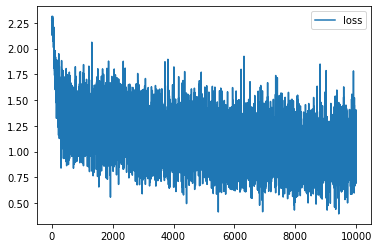

In [ ]:
import matplotlib.pyplot as plt


plt.plot(global_loses, label="loss")
plt.legend()
plt.show()

In [ ]:
metric = load_metric("f1")
classification_model.eval()

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():
        outputs = classification_model(b_input_ids, token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=b_labels)

metric.compute(average='weighted')

{'f1': 0.5940516398051083}

In [ ]:
metric = load_metric("f1")
classification_model.eval()

for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)    
    with torch.no_grad():
        outputs = classification_model(b_input_ids, token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=b_labels)

metric.compute(average='weighted')

{'f1': 0.5837479346473011}

In [ ]:
classification_model.save_pretrained("my_trained_model")

In [ ]:
from google.colab import drive
drive.mount('/content/drive1')

Mounted at /content/drive1


In [ ]:
classification_model.save_pretrained("/drive1/MyDrive/Colab Notebooks/my_trained_model_final")

### 6. Get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)

In [ ]:
model = ElectraForMaskedLM.from_pretrained("/drive1/my_trained_model_final")

Some weights of the model checkpoint at /drive1/my_trained_model_final were not used when initializing ElectraForMaskedLM: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at /drive1/my_trained_model_final and are newly initialized: ['generator_predictions.LayerNorm.weight', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.weight', 'ge

In [ ]:
fill_mask = pipeline(
    "fill-mask",
    model=model,
    tokenizer=tokenizer
)

In [ ]:
fill_mask("Why don't you ask [MASK]?")

[{'score': 0.0004963984247297049,
  'sequence': "why don't you ask roland?",
  'token': 8262,
  'token_str': 'r o l a n d'},
 {'score': 0.00038875287282280624,
  'sequence': "why don't you ask cork?",
  'token': 8513,
  'token_str': 'c o r k'},
 {'score': 0.000338789657689631,
  'sequence': "why don't you ask musically?",
  'token': 21385,
  'token_str': 'm u s i c a l l y'},
 {'score': 0.0003293266927357763,
  'sequence': "why don't you ask declan?",
  'token': 16494,
  'token_str': 'd e c l a n'},
 {'score': 0.0003238604112993926,
  'sequence': "why don't you ask c1?",
  'token': 27723,
  'token_str': 'c 1'}]

In [ ]:
fill_mask("What is [MASK]")

[{'score': 0.0003147227980662137,
  'sequence': 'what is ø',
  'token': 1100,
  'token_str': 'ø'},
 {'score': 0.0003040971059817821,
  'sequence': 'what is latter',
  'token': 3732,
  'token_str': 'l a t t e r'},
 {'score': 0.0003015323309227824,
  'sequence': 'what is erich',
  'token': 17513,
  'token_str': 'e r i c h'},
 {'score': 0.0003008483035955578,
  'sequence': 'what is rune',
  'token': 23276,
  'token_str': 'r u n e'},
 {'score': 0.00029540786636061966,
  'sequence': 'what is ▪',
  'token': 1618,
  'token_str': '▪'}]

In [ ]:
fill_mask("Let's talk about [MASK] physics")

[{'score': 0.00041506870184093714,
  'sequence': "let's talk about itv physics",
  'token': 11858,
  'token_str': 'i t v'},
 {'score': 0.000353406387148425,
  'sequence': "let's talk about moffat physics",
  'token': 28528,
  'token_str': 'm o f f a t'},
 {'score': 0.00035290775122120976,
  'sequence': "let's talk about amnesia physics",
  'token': 29222,
  'token_str': 'a m n e s i a'},
 {'score': 0.0003326046571601182,
  'sequence': "let's talk aboutmeric physics",
  'token': 25531,
  'token_str': '# # m e r i c'},
 {'score': 0.00030204604263417423,
  'sequence': "let's talk about maguire physics",
  'token': 26196,
  'token_str': 'm a g u i r e'}]

As you can see, the predictions differ from the original ones. This happened because when training the model, I trained it as a whole, so the weights of the layers of the MaskedLM model changed noticeably during the training process, and therefore the result of the predictions is different. However, if I trained only the last classifying layer and froze the previous ones, then the result would have to be the same as the original model.

### 7.Tune the training hyperparameters (and write down your results).

I spent quite a lot of time trying to get the best metrics. However, the GPU running time on the Collab is over and I managed to achieve a better result wighted f1 = 0.5837 on val dataset (the f1 metric is calculated above) with the following hyperparameter values.

- Optimizer: AdamW
- Learning rate: 5e-5
- Eps: 1e-8
- Epoches: 4
- Dataset for train: 80000
- Dataset for test: 20000
- Dataset for validation: 30000